Cell lines are a bit of a mess, especially CCLE, since it doesn't have stable identifiers. This notebook uses PyOBO to assess if and to what extent mapping away from CCLE is possible.

In [53]:
import getpass
import itertools as itt
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import pyobo
import seaborn as sns
from pyobo.utils.io import write_map_tsv

In [47]:
print(sys.version)

3.9.5 (default, May  4 2021, 03:36:27) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [48]:
print(time.asctime())

Wed Jul  7 15:32:11 2021


In [49]:
print(getpass.getuser())

cthoyt


In [50]:
print(pyobo.get_version())

0.5.1-dev


In [1]:
prefixes = sorted([
    'ccle.cell',
    'cellosaurus',
    'efo',
    'clo',
    'cl',
    'depmap',
])

In [2]:
prefix_to_identifiers = {}
for prefix in prefixes:
    try:
        prefix_to_identifiers[prefix] = pyobo.get_ids(prefix, strict=False)
    except Exception:
        continue

INFO: [2021-07-07 15:14:42] pyobo.api.names - [cl] no cached names found. getting from OBO loader
INFO: [2021-07-07 15:14:42] pyobo.struct.struct - [cl] parsing with obonet from /Users/cthoyt/.data/pyobo/raw/cl/cl-full.obo
INFO: [2021-07-07 15:14:44] pyobo.struct.struct - [cl] extracting OBO using obonet
INFO: [2021-07-07 15:14:44] pyobo.struct.struct - [cl] does not report a date
INFO: [2021-07-07 15:14:44] pyobo.struct.struct - [cl] using version 2021-03-05
INFO: [2021-07-07 15:14:45] pyobo.struct.struct - [cl] got 9383 references, 244 typedefs, 2311 terms, 73 alt ids, 3259 parents, 2312 synonyms, 2956 relations, and 35 properties
INFO: [2021-07-07 15:14:45] pyobo.struct.struct - [cl] caching metadata to /Users/cthoyt/.data/pyobo/raw/cl/metadata.json
INFO: [2021-07-07 15:14:45] pyobo.struct.struct - [cl] caching metadata to /Users/cthoyt/.data/pyobo/raw/cl/2021-03-05/cache/metadata.json
INFO: [2021-07-07 15:14:45] pyobo.struct.struct - [cl] caching typedefs to /Users/cthoyt/.data/pyo

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0000282', using 'mouse x mouse hybridoma cell line cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0000283', using 'immortal uterine cervix-derived epithelial cell line cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0000284', using 'immortal ileocecal junction-derived cell line cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0000292', using 'immortal larynx-derived cell line cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-p

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0004008', using 'Hs 578Bst cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0004009', using 'Hs 578T cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0004009', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0004046', using 'Hs 683 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0004094', using 'Hs 746T cell'
  self._extract_term(class_,

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0009017', using 'SiHa cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0009017', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0009034', using 'SK-BR-3 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0009035', using 'SK-CO-1 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0009035', concatenating
  self._extract_term(class_, curies)
/U

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0015478', using 'GM03671 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0015478', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0017237', using 'GM03571 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0017237', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0017240', using 'GM03570 cell'
  self._extract_term(class_, curies)

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0050811', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0050812', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0050813', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0050814', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0050815', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtu

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0051980', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0051981', using 'NICR1548 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0051981', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0051982', using 'NICR1583 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0051982', concatenating
  self._extract_term(class_, curies)
/Use

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052423', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052424', using 'NICR544 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052424', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052425', using 'NICR561 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052425', concatenating
  self._extract_term(class_, curies)
/Users

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052907', using 'NICR367 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052907', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052908', using 'NICR409 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052909', using 'NICR1481 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0052909', concatenating
  self._extract_term(class_, curies

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053390', using 'NICR928 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053390', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053391', using 'NICR929 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053391', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053392', using 'NICR930 cell'
  self._extract_term(class_, curies)

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053891', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053892', using 'NICR2165 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053892', concatenating
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053893', using 'NICR2167 cell'
  self._extract_term(class_, curies)
/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'CLO:0053893', concatenating
  self._extract_term(class_, curies)
/Use

INFO: [2021-07-07 15:14:55] pyobo.api.names - [depmap] no cached names found. getting from OBO loader
INFO: [2021-07-07 15:14:55] pyobo.getters - [depmap] caching nomenclature plugin
INFO: [2021-07-07 15:14:55] pyobo.struct.struct - [depmap] caching metadata to /Users/cthoyt/.data/pyobo/raw/depmap/metadata.json
INFO: [2021-07-07 15:14:55] pyobo.struct.struct - [depmap] caching metadata to /Users/cthoyt/.data/pyobo/raw/depmap/21Q2/cache/metadata.json
INFO: [2021-07-07 15:14:55] pyobo.struct.struct - [depmap] caching typedefs to /Users/cthoyt/.data/pyobo/raw/depmap/21Q2/cache/typedefs.tsv
INFO: [2021-07-07 15:14:55] pyobo.struct.struct - [depmap] caching relation obo:is_a ! is a


In [35]:
mappings = {}

for p1, p2 in itt.product(prefix_to_identifiers, repeat=2):
    if p1 == p2:
        continue
    mappings[p1, p2] = pyobo.get_filtered_xrefs(p1, p2)

In [31]:
data = pd.DataFrame(columns=['from_prefix', 'to_prefix', 'n'], data=[
    (from_prefix, to_prefix, len(m))
    for (from_prefix, to_prefix), m in mappings.items()
]).pivot('from_prefix', 'to_prefix').fillna(0.0).astype(int)
data

n                            
to_prefix   ccle.cell cellosaurus cl depmap   efo
from_prefix                                      
ccle.cell           0           0  0   1457     0
cellosaurus         0           0  0   1788  1296
cl                  0           0  0      0     1
depmap              0        1678  0      0     0
efo                 0           0  2      0     0

<AxesSubplot:xlabel='None-to_prefix', ylabel='from_prefix'>

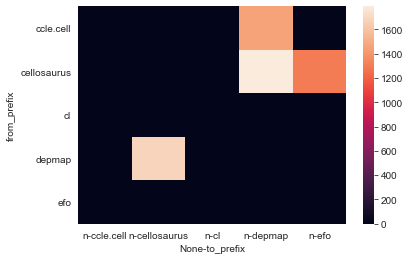

In [33]:
sns.set_style('whitegrid')
sns.heatmap(data)

In [ ]:
def cdict(x):
    return {k:v for k,v in x if v}

In [54]:
# map from CCLE to DepMap to Cellosaurus to EFO

ccle_depmap = pyobo.get_filtered_xrefs('ccle', 'depmap')

ccle_cellosaurus = cdict(
    (ccle_id, pyobo.get_xref('depmap', depmap_id, 'cellosaurus'))
    for ccle_id, depmap_id in ccle_depmap.items()
)

print('Got', len(ccle_depmap), 'mappings from CCLE to DepMap')
print('Got', len(ccle_cellosaurus), 'mappings from CCLE to Cellosaurus via DepMap')

Got 1457 mappings from CCLE to DepMap
Got 1444 mappings from CCLE to Cellosaurus via DepMap


In [55]:
ccle_efo = cdict(
    (ccle_id, pyobo.get_xref('cellosaurus', cvcl_id, 'efo'))
    for ccle_id, cvcl_id in ccle_cellosaurus.items()
)

print('Got', len(ccle_efo), 'mappings from CCLE to EFO (via DepMap then Cellosaurus)')

Got 714 mappings from CCLE to EFO (via DepMap then Cellosaurus)


In [57]:
write_map_tsv(path='ccle_depmap.tsv', header=['ccle', 'depmap'], rv=ccle_depmap)
write_map_tsv(path='ccle_cellosaurus.tsv', header=['ccle', 'cellosaurus'], rv=ccle_cellosaurus)
write_map_tsv(path='ccle_efo.tsv', header=['ccle', 'efo'], rv=ccle_efo)